# Kr NEW Compare KrMap - ICAROS Map

J. A Hernando, C. Herves

May 2022

In [1]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
from   scipy             import stats
from   scipy             import optimize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.profile      as prof

import nana.kr.krana    as krana
import nana.kr.icaros   as icaros

#import nana.bclouds.bclouds      as bc
#import hipy.hfit         as hfit
from invisible_cities.io.dst_io import load_dst, load_dsts
#import invisible_cities.io.dst_io as dio

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Thu May 12 12:20:39 2022


In [5]:
#import os
import re
import glob

from collections import namedtuple

## Access Data

In [6]:
path = '/Users/hernando/work/investigacion/NEXT/data/NEW/'
runs = 8182, 8183, 8184
filenames = [path+'/chits_ds_rough_'+str(run)+'.h5' for run in runs]

In [7]:
namehits = 'high' 
dat      = pd.read_hdf(filenames[0], '/CHITs.'+namehits+'Th')

In [8]:
dat.columns

Index(['event', 'time', 'npeak', 'Xpeak', 'Ypeak', 'nsipm', 'X', 'Y', 'Xrms',
       'Yrms', 'Z', 'Q', 'E', 'Qc', 'Ec', 'track_id', 'Ep'],
      dtype='object')

## Access Maps

In [9]:
run = runs[0]
mapfilename = path + 'Kr/maps/map_' + str(run) + '.h5'
icaromap  = icaros.get_map(mapfilename)
icarocorz = icaros.get_corrz(icaromap)

drift velocity  0.9248098826413511


In [10]:
x    = dat.X.values 
y    = dat.Y.values
z    = dat.Z.values
time = dat.time.values 
ene  = dat.E.values
enec = ene * icarocorz(x, y, z, time)
dat['enec'] = enec
#ene   = dat.groupby('event')['E'].sum()

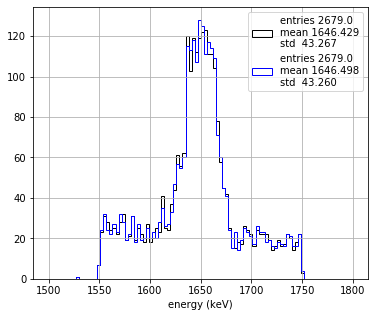

In [14]:
canvas = pltext.canvas(1, 1)
evtene = dat.groupby('event')['enec'].sum()
pltext.hist(1e3*evtene, 100, (1500, 1800));
evtene0 = dat.groupby('event')['Ec'].sum()
pltext.hist(1e3*evtene0, 100, (1500, 1800));
plt.xlabel('energy (keV)');

## Read KrMap 

In [15]:
krmap  = krana.krmap_read('krmap' , 'krmap_'+str(run)+'.h5', 'KrMap')
xyprof = krana.krmap_read('xyprof', 'krmap_'+str(run)+'.h5', 'Profile')

In [16]:
vdrift   = 0.9248098826413511
coors    = (x, y)
dtime    = z/vdrift
ones     = np.ones(len(x))
ene      = dat.E.values
kene0, _ = krana.krmap_scale (coors, dtime, ene  , krmap , scale = 41.55)
kene0[np.isnan(kene0)] = 0.
kene1    = prof.profile_scale(coors, kene0, xyprof, scale = 41.55)

In [17]:
dat['kene0'] = kene0
dat['kene1'] = kene1

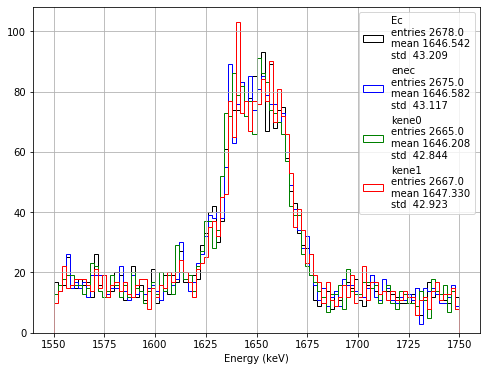

In [23]:
pltext.canvas(1, 1, 6, 8)
for name in ('Ec', 'enec', 'kene0', 'kene1'):
    evtene = dat.groupby('event')[name].sum()
    evtene = 1e3 * evtene if name in ['Ec', 'enec'] else evtene
    pltext.hist(evtene, 100, (1550., 1750.), label = name);
plt.xlabel('Energy (keV)');

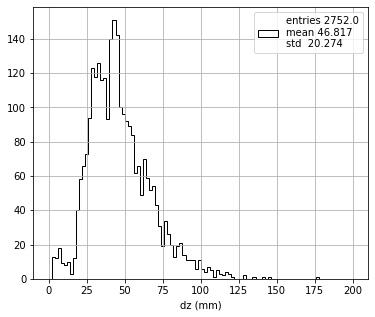

In [24]:
pltext.canvas(1, 1)
zmin = dat.groupby('event')['Z'].min()
zmax = dat.groupby('event')['Z'].max()
dz   = zmax - zmin
pltext.hist(dz, 100, (0, 200));
plt.xlabel('dz (mm)');

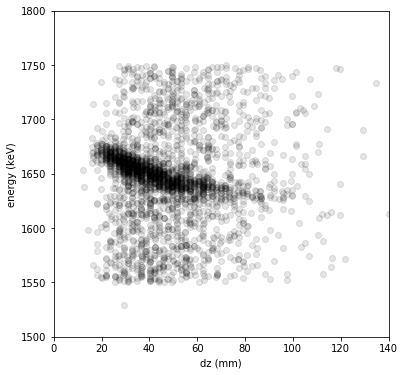

In [25]:
pltext.canvas(1, 1, 6, 6)
ene  = 1e3 * dat.groupby('event')['Ec'].sum()
zmin = dat.groupby('event')['Z'].min()
zmax = dat.groupby('event')['Z'].max()
dz   = zmax - zmin
plt.scatter(dz, ene, alpha = 0.1);
plt.xlim((0, 140)); plt.ylim((1500., 1800));
plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)');

In [26]:
def get_dzprof(enename = 'Ec'):
    ene     = dat.groupby('event')[enename].sum()
    zmin    = dat.groupby('event')['Z'].min()
    zmax    = dat.groupby('event')['Z'].max()
    dz      = zmax - zmin
    sel     = np.ones(len(dz), bool)
    clean   = np.copy(sel)
    clean   = ut.in_range(dz, (0., 130))
    done    = False
    while (not done):
        dz0     = dz[clean]
        ene0    = ene[clean]
        dzprof  = prof.profile((dz0,), ene0, bins = 50, counts_min = 20)
        done, usel = krana.accept_residuals(dzprof.residuals, range = (-2.,2.), 
                                            fun = 'gaus+poly.1', min_sigma = 0.7)
        clean[clean == True] = usel
    return dz, ene, clean, dzprof

In [27]:
def plot_dzprof(dz, ene, sel, dzprof):
    ecor   = prof.profile_scale(dz, ene, dzprof, 1600.)
    canvas = pltext.canvas(2, 2)
    canvas(1)
    pltext.hist(ecor[sel], 100, (1540., 1650));
    pltext.hfit(ecor[sel], 100, range = (1540., 1650.), fun = 'gaus+poly.1');
    canvas(2)
    plt.scatter(dz[sel], ecor[sel], alpha = 0.1);
    plt.xlim((0., 200));plt.ylim((1400., 1800.)); plt.xlim((0., 130));
    return

sigma 0.30 done  False  eff 74.85
cleanning  False 2057 0.7452898550724638
sigma 0.48 done  False  eff 88.58
cleanning  False 1822 0.6601449275362319
sigma 0.61 done  False  eff 95.55
cleanning  False 1741 0.6307971014492754
sigma 0.68 done  False  eff 98.56
cleanning  False 1716 0.6217391304347826
sigma 0.70 done  True  eff 100.00
cleanning  True 1716 0.6217391304347826


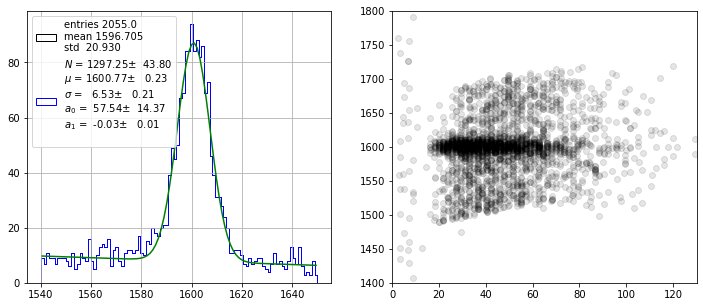

In [34]:
dz, ene, sel, dzprof = get_dzprof()
plot_dzprof(dz, ene, np.ones(len(dz), bool), dzprof)
cene = prof.profile_scale((dz,), ene, dzprof, 1600.)

sigma 0.30 done  False  eff 74.75
cleanning  False 2054 0.7442028985507246
sigma 0.51 done  False  eff 89.78
cleanning  False 1844 0.6681159420289855
sigma 0.62 done  False  eff 95.50
cleanning  False 1761 0.6380434782608696
sigma 0.63 done  False  eff 96.76
cleanning  False 1704 0.6173913043478261
sigma 0.73 done  True  eff 100.00
cleanning  True 1704 0.6173913043478261


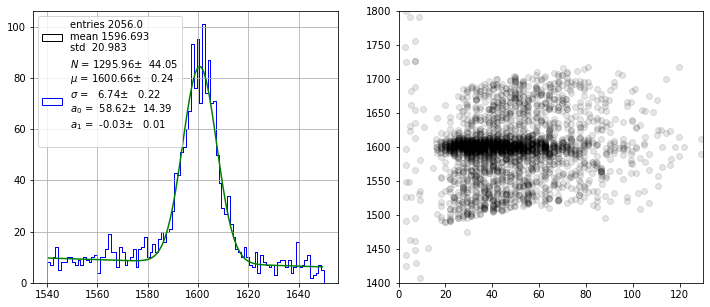

In [35]:
dz, enec, sel, dzprof = get_dzprof('enec')
plot_dzprof(dz, enec, np.ones(len(dz), bool), dzprof)
cenec = prof.profile_scale((dz,), enec, dzprof, 1600.)

sigma 0.29 done  False  eff 74.13
cleanning  False 2037 0.7380434782608696
sigma 0.50 done  False  eff 89.35
cleanning  False 1820 0.6594202898550725
sigma 0.60 done  False  eff 95.38
cleanning  False 1736 0.6289855072463768
sigma 0.67 done  False  eff 98.27
cleanning  False 1706 0.6181159420289855
sigma 0.69 done  False  eff 98.94
cleanning  False 1688 0.6115942028985507
sigma 0.71 done  True  eff 100.00
cleanning  True 1688 0.6115942028985507


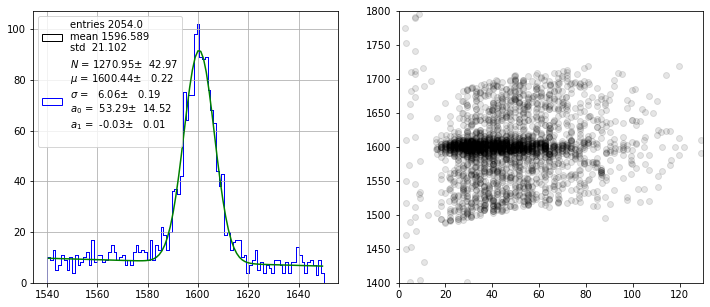

In [36]:
dz, ene0, sel, dzprof = get_dzprof('kene0')
plot_dzprof(dz, ene0, np.ones(len(dz), bool), dzprof)
cene0 = prof.profile_scale((dz,), ene0, dzprof, 1600.)

sigma 0.29 done  False  eff 73.73
cleanning  False 2026 0.7340579710144928
sigma 0.49 done  False  eff 88.80
cleanning  False 1799 0.6518115942028986
sigma 0.60 done  False  eff 95.11
cleanning  False 1711 0.619927536231884
sigma 0.71 done  True  eff 100.00
cleanning  True 1711 0.619927536231884


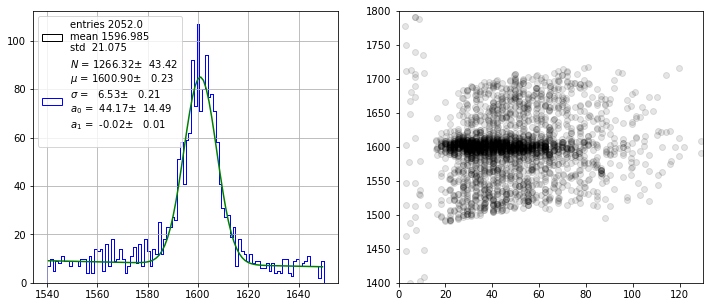

In [37]:
dz, ene1, sel, dzprof = get_dzprof('kene1')
plot_dzprof(dz, ene1, np.ones(len(dz), bool), dzprof)
cene1 = prof.profile_scale((dz,), ene1, dzprof, 1600.)

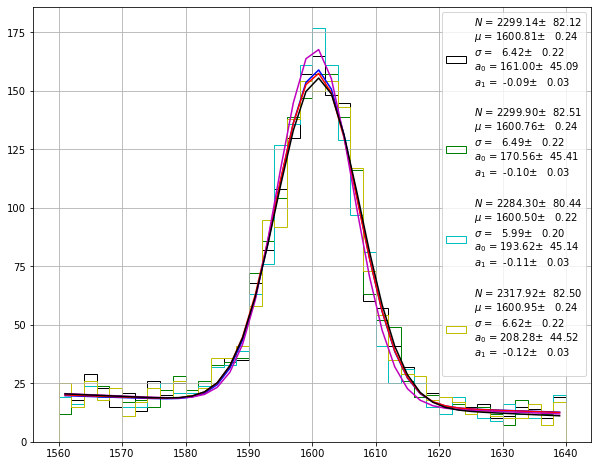

In [38]:
canvas = pltext.canvas(1, 1, 8, 10)
bins, range = 40, (1560, 1640)
pltext.hfit(cene , bins, range = range, fun = 'gaus+poly.1');
pltext.hfit(cenec, bins, range = range, fun = 'gaus+poly.1');
pltext.hfit(cene0, bins, range = range, fun = 'gaus+poly.1');
pltext.hfit(cene1, bins, range = range, fun = 'gaus+poly.1');

In [42]:
(6.0/1600) * 235.5 * np.sqrt(1.6/2.458)

0.7125104384486526